# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [26]:
# Standard modules imported
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from IPython.display import display, Markdown
import ae353_spacecraft_design as design
import control

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

## Create spacecraft
create and visuallize the spacecraft. The four reaction wheels are defined in terms of their right ascension $\alpha$ and declination $\delta$.

In [27]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

#Defines wheel positions
wheels = [
    {'alpha': 1 * np.pi / 2, 'delta': 0.},
    {'alpha': np.pi, 'delta': 0.},
    {'alpha': 3 * np.pi / 2, 'delta': 0.},
    {'alpha': 0, 'delta': -1 * np.pi / 2.},
]

#shows wheels on space craft
design.show_wheels(vis, wheels)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


Generate the space craft in URDF format and calculates mass $m$ and $J$

In [28]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}26.08 & 0.0 & 0.0\\0.0 & 23.72 & 0.0\\0.0 & 0.0 & 26.08\end{matrix}\right]$$

## Create stars
determine their placement in right ascension $\alpha$ and declination $\delta$. Show the stars and save them as a UDRF file.

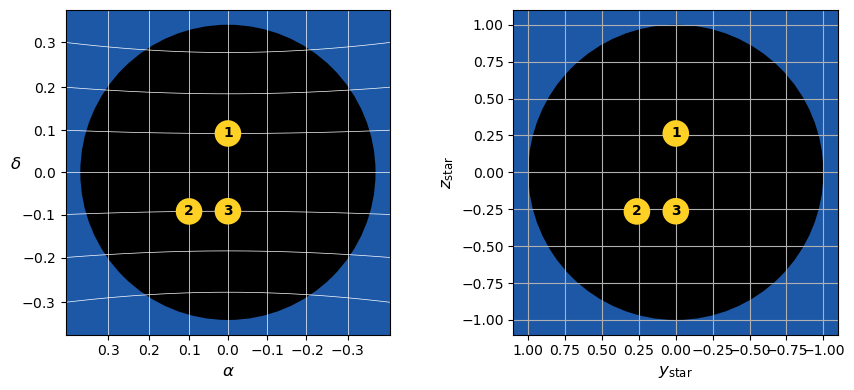

In [29]:
stars = [
    {'alpha':  0, 'delta':  .1},
    {'alpha':  .1, 'delta':  -.1},
    {'alpha':  0, 'delta':  -.1},
]
#show the stars
design.show_stars(stars)
#save the stars as a UDRF file
design.create_stars(stars)

## Create dynamic model
This section will derive the equations of motion

In [30]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

Linearize the equations of motion, $f$, to find the values of $A$ and $B$

In [31]:
from scipy import linalg
#compute A
anum = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian((psi,theta,phi,w_x,w_y,w_z)))
A = anum(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)
#compute B
bnum = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian((tau_1,tau_2,tau_3,tau_4)))
B = bnum(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Confirm that the system is controlable

In [32]:
W = B
for i in range(1,A.shape[0]):
    col = np.linalg.matrix_power(A,i) @ B
    W = np.block([W,col])
print(np.linalg.matrix_rank(W) == A.shape[0])

True


Compute the gain matrix $K$ using the LQR method

In [33]:
Q = np.eye(6)*100
R = np.eye(4)
P = linalg.solve_continuous_are(A,B,Q,R)
K = linalg.inv(R) @ B.T @ P

## Create sensor model
Create Equations of Measure with $\alpha$ and $\delta$ to define star positions.

In [34]:
#defines star positions
alpha, delta = sym.symbols('alpha, delta')

# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)], [sym.sin(alpha) * sym.cos(delta)], [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]], [p_star_in_body[2] / p_star_in_body[0]]])
g = sym.simplify(p_star_in_image, full = True)

#establish first star with its position
G = g.subs({alpha: 0,delta: .1})

#stack additional stars into Equation of measure matrix
for i in range(1, len(stars)):
    G = np.vstack((G,g.subs({alpha:stars[i]['alpha'], delta: stars[i]['delta']})))

# Sensor model for all the stars
G = sym.simplify(sym.Matrix(G))

Generate $C$ Matrix and use LQR to find $L$

In [35]:
#create the matrix C using EOM G
cnum = sym.lambdify((psi,theta,phi,w_x,w_y,w_z), G.jacobian(([psi,theta,phi,w_x,w_y,w_z])))
C = cnum(0,0,0,0,0,0).T

#Establish Q and R matricies and solve LQR for matrix L
Q0 = np.diag((1,1,1,1,1,1))
R0 = np.diag((1,1,1,1,1,1))*10
P = linalg.solve_continuous_are(A.T,C.T,linalg.inv(R0),linalg.inv(Q0))
L = (Q0 @ C @ P).T

Confirm that the system is observable

In [36]:
#check observalility
W = C.T
for i in range(1,6):
    col = np.linalg.matrix_power(A.T,i) @ C.T
    W = np.block([W,col])
print(np.linalg.matrix_rank(W) == A.shape[0])

True


### Simulation set up
Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.
Toggle `display` when making saving a video or collecting data

try `display=False` and `display_pybullet=True` if there are problems with the display

In [37]:
#starts the simulator
simulator = ae353_spacecraft_simulate.Simulator(display=True, seed=None,)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [38]:
#controls the camera view
simulator.camera_sideview()

Defines a controller that maps sensor measurements to actuator commands. This function is called 25 times per second by the simulator.

In [39]:
class Controller:
    #initializes the controller
    def __init__(self):
        #uses matricies calculated above
        self.K = K
        self.A = A
        self.B = B
        self.C = C
        self.L = L
        
        #sets the time step as 1/25
        self.dt = (1/25)

        #logs the variable in xhat for later analysis
        self.variables_to_log = ['xhat']

    #resets the controller from the last time it was run
    def reset(self):
        #sets xhat to the intended starting position
        self.xhat = np.array([0.0,0.0,0.0,0.0,0.0,0.0]).T
        pass
    
    def run(self, t, star_measurements):
        #input variables tourque are calculated with the gain feedback equation
        u = -self.K@self.xhat
        #the inputs are broken down into their respective wheels
        torque_1 = u[0] #may need to subtract ne
        torque_2 = u[1]
        torque_3 = u[2]
        torque_4 = u[3]

        #sets up y by subtracting the observer equilibrium points from the star measurements
        y = star_measurements - np.array([0, 0.263378514224308, 0.263378514224308, -0.264700916252661, 0, -0.263378514224308])

        #calculate the next xhat value by adding the predicted variation to the exsisting xhat value
        self.xhat += self.dt*(self.A@self.xhat+self.B@u-self.L@(self.C@self.xhat-y))

        #returns the following tourques
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [40]:
controller = Controller()

You could reset the simulator with given initial conditions.

In [41]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [45]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.0,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=10.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [46]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [47]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Check if the space-cat has docked.

In [44]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat did not dock.


Get, show, and save a snapshot of the simulation after the last time step.

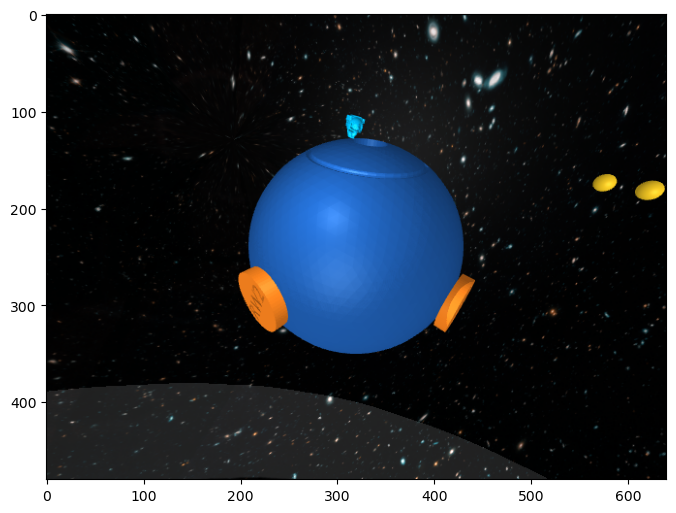

In [25]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

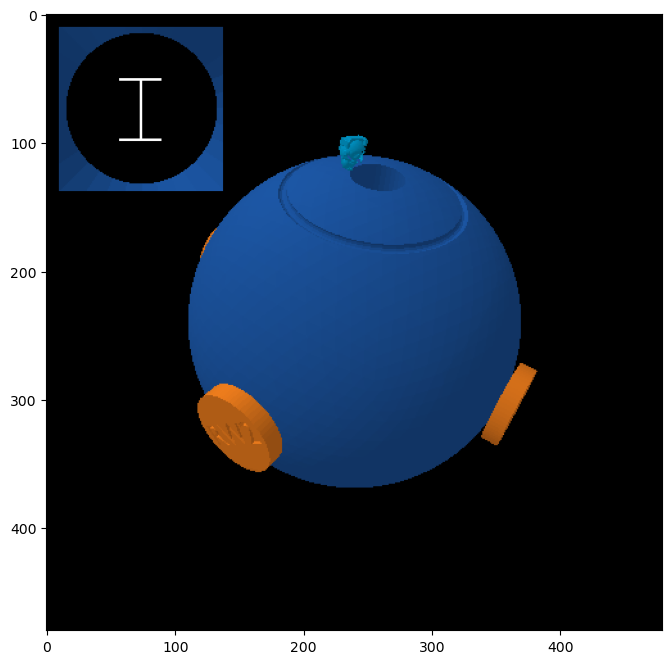

In [26]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

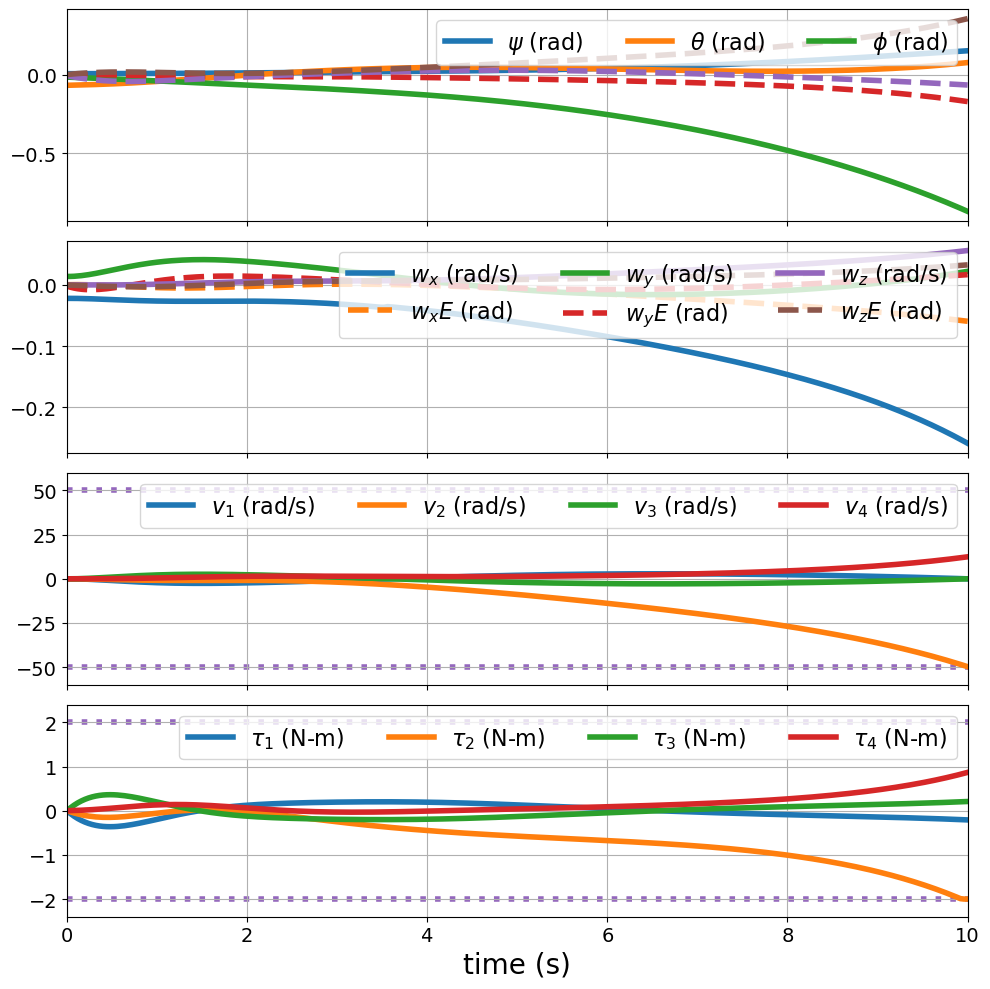

In [49]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

#break down xhat into 1d arrays
xhat = data['xhat']
xhat0 = xhat[:,0]
xhat1 = xhat[:,1]
xhat2 = xhat[:,2]
xhat3 = xhat[:,3]
xhat4 = xhat[:,4]
xhat5 = xhat[:,5]

t = data['t']
# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

#Plot the expected yaw, pitch and roll
ax_ori.plot(t, xhat0, '--' ,label=r'$psiE$ (rad)', linewidth=4)
ax_ori.plot(t, xhat1, '--' ,label=r'$thetaE$ (rad)', linewidth=4)
ax_ori.plot(t, xhat2, '--' ,label=r'$phiE$ (rad)', linewidth=4)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot the expected w_x, w_y, w_z
ax_vel.plot(t, xhat3, '--' ,label=r'$w_xE$ (rad)', linewidth=4)
ax_vel.plot(t, xhat4, '--' ,label=r'$w_yE$ (rad)', linewidth=4)
ax_vel.plot(t, xhat5, '--' ,label=r'$w_zE$ (rad)', linewidth=4)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [83]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

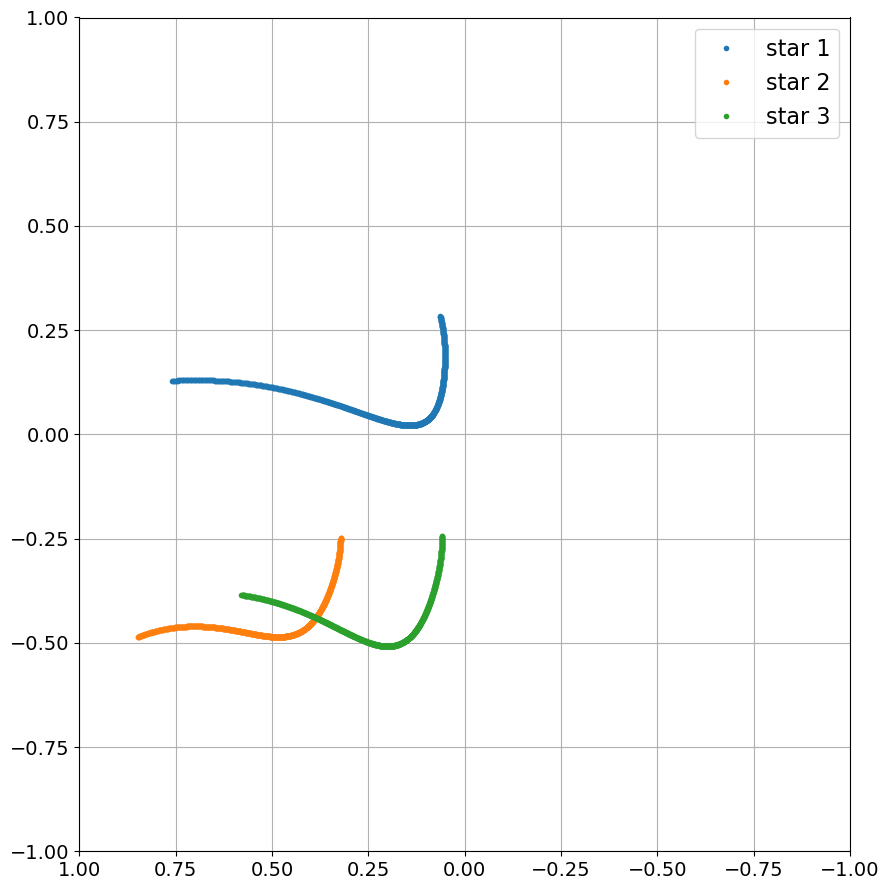

In [84]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()